# MCSA analysis (notebook 1 of 2)

## Libraries, functions and dictionaries

In [3]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic
from graphviz import Digraph

import warnings
warnings.filterwarnings('ignore')

In [4]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [5]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [6]:
def load_data_V2_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [7]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [8]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [9]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [10]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [11]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [12]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [13]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [14]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [15]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [16]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [17]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [18]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [19]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [20]:
def print_chimera_x_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            file.write("\t%s%d\t%f\n" % ('/A:',i+1,attribute[i]))
    file.close()

In [21]:
def print_chimera_x_attribute_file_SBI(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            if attribute_check[i]==1.0:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,1))
            else:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,0))
    file.close()

In [22]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [23]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [24]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [25]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

In [26]:
def print_numbers_classification(pred,mode_pred):

    count_SBI=[0,0,0,0]
    for i in pred:
            count_SBI[int(i)]+=1
    
    variants=count_SBI
    
    count_SBI=[0,0,0,0,0]
    for i in mode_pred:
        if np.isnan(i)!=True:
            if i==5:
                count_SBI[4]+=1
            else:
                count_SBI[int(i)]+=1
    
    return [variants, count_SBI]

In [27]:
def print_catalytic_classification(mode_pred,cat_positions):
    cat_pos=[x - 1 for x in cat_positions]
    cat_pos=np.array(cat_pos)
    count_SBI=[0,0,0,0,0]

    for i,n in enumerate(mode_pred):
        if np.count_nonzero(cat_pos == i)==1:
            if np.isnan(i)!=True:
                if int(n)==5:
                    count_SBI[4]+=1
                else:
                    count_SBI[int(n)]+=1
    
    return  count_SBI

### setup ML functions

In [28]:
def blosum62_score(WT,scores):
    blosum_prot=np.empty((len(WT),20),dtype=float)
    
    for i in range(len(WT)):
        for j in range(20):
            blosum_prot[i,j]=scores[alphabetAA_L_D[WT[i]]-1,j]
            
    return blosum_prot

In [29]:
def secondary_structure_cat(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=False)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    
    for i in range(len(ss_labels[0,:])):
        ss_ret_labels[int(str(chainA_top.residue(i))[3:])-1]=AA_ddsp_number[ss_labels[0,i]]
    
    return ss_ret_labels
    

In [30]:
def secondary_structure_cat_simp(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=True)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    count=1
    for j in range(len(WT)):
        if WT[j]!='-':
            for i in range(len(ss_labels[0,:])):
                if count==int(str(chainA_top.residue(i))[3:]):
                    ss_ret_labels[j]=AA_ddsp_number_simp[ss_labels[0,i]]
            count+=1
    return ss_ret_labels
    

In [31]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [32]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [33]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [34]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [35]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [36]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [37]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [38]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [39]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

In [40]:
def pairplot_features_class(list_feature,name_features,namefile,class_coloured):
    df=pd.DataFrame(list_feature,columns=name_features)
    if class_coloured==1:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y',palette={0:'w',1:'b'})
    elif class_coloured==0:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y',palette={-1:'w',0:'r'}) 
    else:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y')         
    sns_plot.savefig(namefile)

In [41]:
def gemme_prediction(X,X_map,WT,thr,file):
    prediction=np.zeros(len(X),dtype=int)
    for i in range(len(X)):
        if X[i] < thr:
            prediction[i]=1
            
    mode_prediction,percentage=retrieve_residue_label_pred(prediction,X_map,WT,0.50)
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    
    for i in range(len(mode_prediction)):
        if np.isnan(mode_prediction[i])==True:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',-1))
        else:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',percentage[i,0]))
    file.close()

In [42]:
def count_positive_SBI(prediction,perc,sites):
    count_pos=[0,0,0]
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!=True:
            if i+1 in sites:
                if perc[i]>0.5:
                    count_pos[0]+=1
                if perc[i]>0.2 and perc[i]<=0.5:
                    count_pos[1]+=1
                count_pos[2]+=1
                
    
    return count_pos

In [43]:
def index_positive_SBI(prediction,perc,sites):
    index_pos=[]
    index_dpos=[]
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!=True:
            if i+1 in sites:
                if perc[i]>0.5:
                    index_pos.append(i)
                if perc[i]>0.2 and perc[i]<=0.5:
                    index_dpos.append(i)
    
    return index_pos,index_dpos

In [44]:
def index_SBI_db(prediction,sites):
    index_pos=[]
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!=True:
            if i+1 in sites:
                if prediction[i]==1:
                    index_pos.append(i)
    
    return index_pos

In [45]:
def asa_SBI(prediction,asa):
    asa_collect=[]
    for i,n in enumerate(prediction):
        if n==1:
            asa_collect.append(asa[i])
    return asa_collect

In [46]:
def struc_coordinates(pdb_loc,WT,chain='A'):
    alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

    coordinates=np.empty((len(WT),3),dtype=float)
    coordinates[:]=np.nan
    
    fr = open(pdb_loc, 'r')

    for record in fr:
        if(re.search(r'^ATOM\s+\d+\s+CA\s+', record)):
            if chain==(record[21:22]):
                pos=int(record[23:26])
                if alphabetAA_3L_1LC[record[17:20]]!=WT[pos-1]:
                    print(f"WARNING: in pos {pos}, WT sequence AA doesn't match pbd AA")
                    
                coordinates[pos-1,0]=float(record[31:38])
                coordinates[pos-1,1]=float(record[39:46])
                coordinates[pos-1,2]=float(record[47:54])
    
    fr.close()
    
    return coordinates

In [47]:
def AS_CA_distance(CA_coord,AS_pos,target):
    AS_baricenter=np.zeros((3,1),dtype=float)
    
    for i in AS_pos:
        if np.isnan(CA_coord[i-1,:]).any():
            print(f'WARNING - no active site coordinates in pdb for position: {i}')
        else:
            AS_baricenter[0]+=CA_coord[i-1,0]
            AS_baricenter[1]+=CA_coord[i-1,1]
            AS_baricenter[2]+=CA_coord[i-1,2]
        
    AS_baricenter=AS_baricenter/len(AS_pos)

    dist=[-1.0]
    
    if np.isnan(CA_coord[target-1,:]).any():
        pass
        ##print(f'WARNING - no target coordinates in pdb for position: {target}')
    else:
        dist=sp.sqrt((AS_baricenter[0]-CA_coord[target-1,0])**2+(AS_baricenter[1]-CA_coord[target-1,1])**2+(AS_baricenter[2]-CA_coord[target-1,2])**2)
    
    return dist[0]

In [48]:
def SBI_contact_map(CA_coord,SBI_list):
    SBI_CA=[]
    
    for i,n in enumerate(SBI_list):
        if np.count_nonzero(np.isnan(CA_coord[i,:])==True):
            pass
        else:
            SBI_CA.append([n, list(CA_coord[i,:])])
        
    print(len(np.array(SBI_CA)))
    
    SBI_CM=np.empty((len(SBI_CA),len(SBI_CA)),dtype=float)
    SBI_CM[:]=np.nan
    for i in range(len(SBI_CA)):
        for j in range(i,len(SBI_CA)):
                SBI_CM[i,j]=sp.sqrt((SBI_CA[i][1][0]-SBI_CA[j][1][0])**2+(SBI_CA[i][1][1]-SBI_CA[j][1][1])**2+(SBI_CA[i][1][2]-SBI_CA[j][1][2])**2)
                SBI_CM[j,i]=SBI_CM[i,j]
    
    fig,(ax)=plt.subplots(1,2,figsize=(12,6))
    pos=ax[0].imshow(SBI_CM)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(pos,ax=ax[0],cax=cax)
    cbar.ax.tick_params(labelsize=14) 
    
    ax[0].set_yticks([i for i in range(0,len(SBI_CA))])
    ax[0].set_yticklabels([str(SBI_CA[i][0]) for i in range(0,len(SBI_CA))],fontsize=14)
    
    ax[0].set_xticks([i for i in range(0,len(SBI_CA))])
    ax[0].set_xticklabels([str(SBI_CA[i][0]) for i in range(0,len(SBI_CA))],rotation='vertical',fontsize=14)
    
    ax[0].set_xlabel('SBI residue',fontsize=16)
    ax[0].set_ylabel('SBI residue',fontsize=16)
    
    pca=sb.stats.ordination.pcoa(SBI_CM,number_of_dimensions=2)
    df=pca.samples
    
    
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    sil = []
    kmax = 10

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
       # kmeans = KMeans(n_clusters = k,precompute_distances=True).fit(SBI_CM)
        kmeans = KMeans(n_clusters = k).fit(SBI_CM)

        labels = kmeans.labels_
        sil.append(silhouette_score(SBI_CM, labels, metric = 'euclidean'))
        
    
    
    print(np.argmax(sil)+2, sil[np.argmax(sil)])
        
    #kmeans = KMeans(n_clusters=np.argmax(sil)+2,precompute_distances=True).fit(SBI_CM)
    kmeans = KMeans(n_clusters=np.argmax(sil)+2).fit(SBI_CM)

    
    ax[1].scatter(df.iloc[:,0],df.iloc[:,1],c=kmeans.labels_)
    ax[1].set_xlabel('PCA 1',fontsize=16)
    ax[1].set_ylabel('PCA 2',fontsize=16)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    idx=0
    for label, x, y in zip(SBI_list, df.iloc[:,0],df.iloc[:,1]):
        ax[1].annotate(label, (x+0.1,y+0.1), fontsize=14)
        idx+=1

In [49]:
def variants_statistic(prediction,variant_map,WT,rosetta_score,ros_thr):
    alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}

    alphabetAA_L_D_reordered={'H':0,'K':1,'R':2,'D':3,'E':4,'C':5,'M':6,'N':7,'Q':8,'S':9,'T':10,'A':11,'G':12,'I':13,'L':14,'P':15,'V':16,'F':17,'W':18,'Y':19}
    AA_reordered={6:0,8:1,14:2,2:3,3:4,1:5,10:6,11:7,13:8,15:9,16:10,0:11,5:12,7:13,9:14,12:15,17:16,4:17,18:18,19:19}

    
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    SBI_statistic_m=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_over2=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_under2=np.zeros((20,20),dtype=float)
    
    i=0
    
    for cord in variant_map:
        if prediction[i]==1:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                SBI_statistic_m[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        else:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                if rosetta_score[cord[0],cord[1]]>ros_thr:
                    NO_SBI_statistic_m_over2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
                else:
                    NO_SBI_statistic_m_under2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        i+=1

    return [SBI_statistic_m, NO_SBI_statistic_m_under2,NO_SBI_statistic_m_over2]

In [50]:
def variants_statistic(prediction,variant_map,WT):
    alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}

    alphabetAA_L_D_reordered={'H':0,'K':1,'R':2,'D':3,'E':4,'C':5,'M':6,'N':7,'Q':8,'S':9,'T':10,'A':11,'G':12,'I':13,'L':14,'P':15,'V':16,'F':17,'W':18,'Y':19}
    AA_reordered={6:0,8:1,14:2,2:3,3:4,1:5,10:6,11:7,13:8,15:9,16:10,0:11,5:12,7:13,9:14,12:15,17:16,4:17,18:18,19:19}

    
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    SBI_statistic_m=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_over2=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_under2=np.zeros((20,20),dtype=float)
    
    i=0
    
    for cord in variant_map:
        if prediction[i]==1:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                SBI_statistic_m[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        else:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                if prediction[i]==2:
                    NO_SBI_statistic_m_over2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
                if prediction[i]==0:
                    NO_SBI_statistic_m_under2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        i+=1

    return [SBI_statistic_m, NO_SBI_statistic_m_under2,NO_SBI_statistic_m_over2]

In [51]:
def variants_statistic_slice(prediction,variant_map,WT,slice_thr):
    alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}

    alphabetAA_L_D_reordered={'H':0,'K':1,'R':2,'D':3,'E':4,'C':5,'M':6,'N':7,'Q':8,'S':9,'T':10,'A':11,'G':12,'I':13,'L':14,'P':15,'V':16,'F':17,'W':18,'Y':19}
    AA_reordered={6:0,8:1,14:2,2:3,3:4,1:5,10:6,11:7,13:8,15:9,16:10,0:11,5:12,7:13,9:14,12:15,17:16,4:17,18:18,19:19}
    
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    SBI_statistic_m=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_over2=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_under2=np.zeros((20,20),dtype=float)
    
    i=0
    
    for cord in variant_map:
        if prediction[i]==1:
            if WT[cord[0]]!='-' and slice_thr[0] < np.count_nonzero(scores[cord[0],:] == 1)  < slice_thr[1] :
                SBI_statistic_m[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        else:
            if WT[cord[0]]!='-' and slice_thr[0] < np.count_nonzero(scores[cord[0],:] == 1)  < slice_thr[1]:
                if prediction[i]==0:
                    NO_SBI_statistic_m_over2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
                if prediction[i]==2:
                    NO_SBI_statistic_m_under2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        i+=1

    return [SBI_statistic_m, NO_SBI_statistic_m_under2,NO_SBI_statistic_m_over2]

In [52]:
def variants_extract(prediction,variant_map,pos):
    
    scores=np.empty(20,dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            scores[cord[1]]=prediction[i]
        i+=1
            
    return scores

## Load trained model

In [160]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [161]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

## Load MCSA dataset (1/2)

### Q9LAK3

In [53]:
Q9LAK3_WT_sequence="MKKVIIAGNGPSLKEIDYSRLPNDFDVFRCNQFYFEDKYYLGKKCKAVFYNPILFFEQYYTLKHLIQNQEYETELIMCSNYNQAHLENENFVKTFYDYFPDAHLGYDFFKQLKDFNAYFKFHEIYFNQRITSGVYMCAVAIALGYKEIYLSGIDFYQNGSSYAFDTKQKNLLKLAPNFKNDNSHYIGHSKNTDIKALEFLEKTYKIKLYCLCPNSLLANFIELAPNLNSNFIIQEKNNYTKDILIPSSEAYGKFSKNINFKKIKIKENIYYKLIKDLLRLPSDIKHYFKGK"
Q9LAK3_WT_seq_rose="-KKVIIAGNGPSLKEIDYSRLPNDFDVFRCNQFYFEDKYYLGKKCKAVFYNPSLFFEQYYTLKHLIQNQEYETELI-CSNYNQAHLENENFVKTFYDYFPDAHLGYDFFKQLKDFNAYFKFHEIYFNQRITSGVY-CAVAIALGYKEIYLSGIDFYQNGSSYAFDTKQKNLLKLAPNFKNDNSHYIGHSKNTDIKALEFLEKTYKIKLYCLCPNSLLANFIELAPNLNSNFIIQEKNNYTKDILIPSSEAYGKFSKNI---------------------------------"

In [55]:
count=0
for i in range(len(Q9LAK3_WT_sequence)):
    if Q9LAK3_WT_sequence[i]==Q9LAK3_WT_seq_rose[i]:
        count+=1
print(len(Q9LAK3_WT_sequence),count/len(Q9LAK3_WT_seq_rose))

291 0.872852233676976


#### Q9LAK3 active site

In [56]:
Q9LAK3_db_positions=[129,156,162,188]
Q9LAK3_db_positions_array=np.zeros((len(Q9LAK3_WT_sequence)),dtype=int)
for i in Q9LAK3_db_positions:
    Q9LAK3_db_positions_array[i-1]=1

In [57]:
Q9LAK3_db_ligand_positions=[8,9,10,30,31,32,51,54,58,131,132,133,152,153,154,155,156,161,162,177,178,183,188]

#### Co-evolution

In [60]:
Q9LAK3_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q9LAK3.txt',Q9LAK3_WT_sequence)
Q9LAK3_GEMME=remove_WT_score(Q9LAK3_GEMME,Q9LAK3_WT_sequence)

In [62]:
Q9LAK3_GEMME_mean=position_mean(Q9LAK3_GEMME)

####  Rosetta ddG

In [63]:
Q9LAK3_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q9LAK3.txt",Q9LAK3_WT_seq_rose,0)
Q9LAK3_rosetta_ddg=remove_WT_score(Q9LAK3_rosetta_ddg,Q9LAK3_WT_seq_rose)

In [64]:
Q9LAK3_rosetta_ddg_norm=normalize_cutoff(Q9LAK3_rosetta_ddg,0.0,5.0)

In [65]:
Q9LAK3_rosetta_ddg_mean=position_mean(Q9LAK3_rosetta_ddg_norm)

In [66]:
Q9LAK3_rosetta_ddg_mean_non=position_mean(Q9LAK3_rosetta_ddg)

#### WT features

In [67]:
Q9LAK3_WT_aa=np.empty(len(Q9LAK3_WT_sequence),dtype=float)
Q9LAK3_WT_aa[:]=np.nan

In [68]:
for i in range(len(Q9LAK3_WT_sequence)):
    Q9LAK3_WT_aa[i]=alphabetAA_L_D[Q9LAK3_WT_sequence[i]]

#### Hydrophobicity

In [69]:
Q9LAK3_hydrophobicity_mut=np.empty((len(Q9LAK3_WT_sequence),20),dtype=float)
Q9LAK3_hydrophobicity_mut[:]=np.nan

In [70]:
for i in range(len(Q9LAK3_WT_sequence)):
    for j in range(20):
        Q9LAK3_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [71]:
Q9LAK3_wcn=WCN('../pdbs/Q9LAK3_1ro7.pdb','ca',Q9LAK3_WT_sequence)

MSE1


#### CA distance

In [164]:
Q9LAK3_Ca_coord=struc_coordinates('../pdbs/Q9LAK3_1ro7.pdb',Q9LAK3_WT_sequence)

#### Neighbor sequences scores:

In [72]:
Q9LAK3_rosetta_neigbor_scores=neighbor_scores(Q9LAK3_rosetta_ddg_mean,1)

Q9LAK3_GEMME_neigbor_scores=neighbor_scores(Q9LAK3_GEMME_mean,1)

### SOR P82385

In [73]:
SOR_WT_sequence="MISETIRSGDWKGEKHVPVIEYEREGELVKVKVQVGKEIPHPNTTEHHIRYIELYFLPEGENFVYQVGRVEFTAHGESVNGPNTSDVYTEPIAYFVLKTKKKGKLYALSYCNIHGLWENEVTLE"
SOR_WT_seq_rose="MISETIRSGDWKGEKHVPVIEYEREGELVKVKVQVGKEIPHPNTTEHHIRYIELYFLPEGENFVYQVGRVEFTAHGESVNGPNTSDVYTEPIAYFVLKTKKKGKLYALSYCNIHGLWENEVTLE"

In [74]:
count=0
for i in range(len(SOR_WT_sequence)):
    if SOR_WT_sequence[i]==SOR_WT_seq_rose[i]:
        count+=1
print(len(SOR_WT_sequence),count/len(SOR_WT_seq_rose))

124 1.0


#### SOR active site

In [75]:
SOR_db_positions=[14,15]
SOR_db_positions_array=np.zeros((len(SOR_WT_sequence)),dtype=int)
for i in SOR_db_positions:
    SOR_db_positions_array[i-1]=1

In [76]:
SOR_db_ligand_positions=[14,16,41,47,111,114]

#### Co-evolution

In [77]:
SOR_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P82385.txt',SOR_WT_sequence)
SOR_GEMME=remove_WT_score(SOR_GEMME,SOR_WT_sequence)

In [78]:
SOR_GEMME_mean=position_mean(SOR_GEMME)

####  Rosetta ddG

In [79]:
SOR_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P82385.txt",SOR_WT_seq_rose,0)
SOR_rosetta_ddg=remove_WT_score(SOR_rosetta_ddg,SOR_WT_seq_rose)

In [80]:
SOR_rosetta_ddg_norm=normalize_cutoff(SOR_rosetta_ddg,0.0,5.0)

In [81]:
SOR_rosetta_ddg_mean=position_mean(SOR_rosetta_ddg_norm)

#### Hydrophobicity

In [82]:
SOR_hydrophobicity_mut=np.empty((len(SOR_WT_sequence),20),dtype=float)
SOR_hydrophobicity_mut[:]=np.nan

In [83]:
for i in range(len(SOR_WT_sequence)):
    for j in range(20):
        SOR_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [84]:
SOR_wcn=WCN('../pdbs/P82385_1do6.pdb','ca',SOR_WT_sequence)

MET1


#### CA distance

In [166]:
SOR_Ca_coord=struc_coordinates('../pdbs/P82385_1do6.pdb',SOR_WT_sequence)

#### Neighbor sequences scores:

In [97]:
SOR_rosetta_neigbor_scores=neighbor_scores(SOR_rosetta_ddg_mean,1)

SOR_GEMME_neigbor_scores=neighbor_scores(SOR_GEMME_mean,1)

### XYNA P09850

In [85]:
XYNA_WT_sequence="MFKFKKNFLVGLSAALMSISLFSATASAASTDYWQNWTDGGGIVNAVNGSGGNYSVNWSNTGNFVVGKGWTTGSPFRTINYNAGVWAPNGNGYLTLYGWTRSPLIEYYVVDSWGTYRPTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFTNHVNAWKSHGMNLGSNWAYQVMATEGYQSSGSSNVTVW"
XYNA_WT_seq_rose="----------------------------ASTDYWQNWTDGGGIVNAVNGSGGNYSVNWSNTGDFVVGKGWTTGSPFRTINYNAGVWAPNGNGYLTLYGWTRSPLIEYYVVDSWGTYRPTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFTNHVNAWKSHGMNLGSNWAYQVMATEGYQSSGSSNVTVW"

In [87]:
count=0
for i in range(len(XYNA_WT_sequence)):
    if XYNA_WT_sequence[i]==XYNA_WT_seq_rose[i]:
        count+=1
print(len(XYNA_WT_sequence),count/len(XYNA_WT_seq_rose))

213 0.863849765258216


#### XYNA active site

In [88]:
XYNA_db_positions=[97,200,108,106,63]
XYNA_db_positions_array=np.zeros((len(XYNA_WT_sequence)),dtype=int)
for i in XYNA_db_positions:
    XYNA_db_positions_array[i-1]=1

In [89]:
XYNA_db_ligand_positions=[35,37,97,144,145,194                       ]

#### Co-evolution

In [90]:
XYNA_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P09850.txt',XYNA_WT_sequence)
XYNA_GEMME=remove_WT_score(XYNA_GEMME,XYNA_WT_sequence)

In [91]:
XYNA_GEMME_mean=position_mean(XYNA_GEMME)

####  Rosetta ddG

In [93]:
XYNA_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P09850.txt",XYNA_WT_seq_rose,0)
XYNA_rosetta_ddg=remove_WT_score(XYNA_rosetta_ddg,XYNA_WT_seq_rose)

In [94]:
XYNA_rosetta_ddg_norm=normalize_cutoff(XYNA_rosetta_ddg,0.0,5.0)

In [95]:
XYNA_rosetta_ddg_mean=position_mean(XYNA_rosetta_ddg_norm)

#### Hydrophobicity

In [207]:
XYNA_hydrophobicity_mut=np.empty((len(XYNA_WT_sequence),20),dtype=float)
XYNA_hydrophobicity_mut[:]=np.nan

In [208]:
for i in range(len(XYNA_WT_sequence)):
    for j in range(20):
        XYNA_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [96]:
XYNA_wcn=WCN('../pdbs/P09850_1c5h.pdb','ca',XYNA_WT_sequence)

ALA29


#### CA distance

In [167]:
XYNA_Ca_coord=struc_coordinates('../pdbs/P09850_1c5h.pdb',XYNA_WT_sequence)

#### Neighbor sequences scores:

In [98]:
XYNA_rosetta_neigbor_scores=neighbor_scores(XYNA_rosetta_ddg_mean,1)

XYNA_GEMME_neigbor_scores=neighbor_scores(XYNA_GEMME_mean,1)

### MURL P56868

In [99]:
MURL_WT_sequence="MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDTIIRYSLECAGFLKDKGVDIIVVACNTASAYALERLKKEINVPVFGVIEPGVKEALKKSRNKKIGVIGTPATVKSGAYQRKLEEGGADVFAKACPLFVPLAEEGLLEGEITRKVVEHYLKEFKGKIDTLILGCTHYPLLKKEIKKFLGDVEVVDSSEALSLSLHNFIKDDGSSSLELFFTDLSPNLQFLIKLILGRDYPVKLAEGVFTH"
MURL_WT_seq_rose="MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDTIIRYSLECAGFLKDKGVDIIVVACNTASAYALERLKKEINVPVFGVIEPGVKEALKKSRNKKIGVIGTPATVKSGAYQRKLEEGGADVFAKACPLFAPLAEEGLLEGEITRKVVEHYLKEFKGKIDTLILGCTHYPLLKKEIKKFLGDAEVVDSSEALSLSLHNFIKDDGSSSLELFFTDLSPNLQFLIKLILGRDYPVKLAEGVF--"

In [100]:
count=0
for i in range(len(MURL_WT_sequence)):
    if MURL_WT_sequence[i]==MURL_WT_seq_rose[i]:
        count+=1
print(len(MURL_WT_sequence),count/len(MURL_WT_seq_rose))

254 0.984251968503937


#### MURL active site

In [101]:
MURL_db_positions=[7,8,178,147,70,180]

In [102]:
MURL_db_ligand_positions=[69,70,71,177,178]

#### Co-evolution

In [103]:
MURL_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P56868.txt',MURL_WT_sequence)
MURL_GEMME=remove_WT_score(MURL_GEMME,MURL_WT_sequence)

In [104]:
MURL_GEMME_mean=position_mean(MURL_GEMME)

####  Rosetta ddG

In [106]:
MURL_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P56868.txt",MURL_WT_seq_rose,0)
MURL_rosetta_ddg=remove_WT_score(MURL_rosetta_ddg,MURL_WT_seq_rose)

In [107]:
MURL_rosetta_ddg_norm=normalize_cutoff(MURL_rosetta_ddg,0.0,5.0)

In [108]:
MURL_rosetta_ddg_mean=position_mean(MURL_rosetta_ddg_norm)

#### Hydrophobicity

In [235]:
MURL_hydrophobicity_mut=np.empty((len(MURL_WT_sequence),20),dtype=float)
MURL_hydrophobicity_mut[:]=np.nan

In [236]:
for i in range(len(MURL_WT_sequence)):
    for j in range(20):
        MURL_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [154]:
MURL_wcn=WCN('../pdbs/P56868_1b73.pdb','ca',MURL_WT_sequence)

MET1


#### CA distance

In [168]:
MURL_Ca_coord=struc_coordinates('../pdbs/P56868_1b73.pdb',MURL_WT_sequence)

#### Neighbor sequences scores:

In [241]:
MURL_rosetta_neigbor_scores=neighbor_scores(MURL_rosetta_ddg_mean,1)

MURL_GEMME_neigbor_scores=neighbor_scores(MURL_GEMME_mean,1)

### P0A7E3

In [109]:
P0A7E3_WT_sequence="MKPYQRQFIEFALSKQVLKFGEFTLKSGRKSPYFFNAGLFNTGRDLALLGRFYAEALVDSGIEFDLLFGPAYKGIPIATTTAVALAEHHDLDLPYCFNRKEAKDHGEGGNLVGSALQGRVMLVDDVITAGTAIRESMEIIQANGATLAGVLISLDRQERGRGEISAIQEVERDYNCKVISIITLKDLIAYLEEKPEMAEHLAAVKAYREEFGV"
P0A7E3_WT_seq_rose="MKPYQRQFIEFALSKQVLKFGEFTLKSGRKSPYFFNAGLFNTGRDLALLGRFYAEALVDSGIEFDLLFGPAYKGIPIATTTAVALAEHHDLDLPYCFNRKEAKDHGEGGNLVGSALQGRVMLVDDVITAGTAIRESMEIIQANGATLAGVLISLDRQERGRGEISAIQEVERDYNCKVISIITLKDLIAYLEEKPEMAEHLAAVKAYREEFGV"

In [110]:
count=0
for i in range(len(P0A7E3_WT_sequence)):
    if P0A7E3_WT_sequence[i]==P0A7E3_WT_seq_rose[i]:
        count+=1
print(len(P0A7E3_WT_sequence),count/len(P0A7E3_WT_seq_rose))

213 1.0


#### P0A7E3 active site

In [111]:
P0A7E3_db_positions=[103,105]
P0A7E3_db_positions_array=np.zeros((len(P0A7E3_WT_sequence)),dtype=int)
for i in P0A7E3_db_positions:
    P0A7E3_db_positions_array[i-1]=1

#### Co-evolution

In [113]:
P0A7E3_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P0A7E3.txt',P0A7E3_WT_sequence)
P0A7E3_GEMME=remove_WT_score(P0A7E3_GEMME,P0A7E3_WT_sequence)

In [114]:
P0A7E3_GEMME_mean=position_mean(P0A7E3_GEMME)

####  Rosetta ddG

In [115]:
P0A7E3_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P0A7E3.txt",P0A7E3_WT_seq_rose)
P0A7E3_rosetta_ddg=remove_WT_score(P0A7E3_rosetta_ddg,P0A7E3_WT_seq_rose)

In [116]:
P0A7E3_rosetta_ddg_norm=normalize_cutoff(P0A7E3_rosetta_ddg,0.0,5.0)

In [117]:
P0A7E3_rosetta_ddg_mean=position_mean(P0A7E3_rosetta_ddg_norm)

#### Hydrophobicity

In [258]:
P0A7E3_hydrophobicity_mut=np.empty((len(P0A7E3_WT_sequence),20),dtype=float)
P0A7E3_hydrophobicity_mut[:]=np.nan

In [259]:
for i in range(len(P0A7E3_WT_sequence)):
    for j in range(20):
        P0A7E3_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [155]:
P0A7E3_wcn=WCN('../pdbs/P0A7E3_1oro.pdb','ca',P0A7E3_WT_sequence)

MET1


#### CA distance

In [171]:
P0A7E3_Ca_coord=struc_coordinates('../pdbs/P0A7E3_1oro.pdb',P0A7E3_WT_sequence)

#### Neighbor sequences scores:

In [264]:
P0A7E3_rosetta_neigbor_scores=neighbor_scores(P0A7E3_rosetta_ddg_mean,1)

P0A7E3_GEMME_neigbor_scores=neighbor_scores(P0A7E3_GEMME_mean,1)

### SP2AB O32727

In [118]:
SP2AB_WT_sequence="MRNEMHLQFSARSENESFARVTVAAFVAQLDPTTDELTEIKTVVSEAVTNAIIHGYNNDPNGIVSISVIIEDGVVHLTVRDEGVGIPDIEEARQPLFTTKPELERSGMGFTIMENFMDEVIVESEVNKGTTVYLKKAYCEKQTLCN"
SP2AB_WT_seq_rose="MRNEMHLQFSARSENESFARVTVAAFVAQLDPTMDELTEIKTVVSEAVTNAIIHGYNNDPNGIVSISVIIEDGVVHLTVRDEGVGIPDIEEARQPLFTTKPELERSGMGFTIMENFMDEVIVESEVNKGTTVYLKK----------"

In [119]:
count=0
for i in range(len(SP2AB_WT_sequence)):
    if SP2AB_WT_sequence[i]==SP2AB_WT_seq_rose[i]:
        count+=1
print(len(SP2AB_WT_sequence),count/len(SP2AB_WT_seq_rose))

146 0.9246575342465754


#### SP2AB active site

In [120]:
SP2AB_db_positions=[46,50,105]

In [121]:
SP2AB_db_ligand_positions=[50,51,54,55,81,86,92,97,98,99,105,106,108,109,110]

#### Co-evolution

In [122]:
SP2AB_GEMME=load_data_V2('../scores_GEMME/prism_gemme_O32727.txt',SP2AB_WT_sequence)
SP2AB_GEMME=remove_WT_score(SP2AB_GEMME,SP2AB_WT_sequence)

In [123]:
SP2AB_GEMME_mean=position_mean(SP2AB_GEMME)

####  Rosetta ddG

In [124]:
SP2AB_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_O32727.txt",SP2AB_WT_seq_rose,0)
SP2AB_rosetta_ddg=remove_WT_score(SP2AB_rosetta_ddg,SP2AB_WT_seq_rose)

In [125]:
SP2AB_rosetta_ddg_norm=normalize_cutoff(SP2AB_rosetta_ddg,0.0,5.0)

In [126]:
SP2AB_rosetta_ddg_mean=position_mean(SP2AB_rosetta_ddg_norm)

#### Hydrophobicity

In [285]:
SP2AB_hydrophobicity_mut=np.empty((len(SP2AB_WT_sequence),20),dtype=float)
SP2AB_hydrophobicity_mut[:]=np.nan

In [286]:
for i in range(len(SP2AB_WT_sequence)):
    for j in range(20):
        SP2AB_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [156]:
SP2AB_wcn=WCN('../pdbs/O32727_1l0o.pdb','ca',SP2AB_WT_sequence)

MET1


#### CA distance

In [172]:
SP2AB_Ca_coord=struc_coordinates('../pdbs/O32727_1l0o.pdb',SP2AB_WT_sequence)

#### Neighbor sequences scores:

In [291]:
SP2AB_rosetta_neigbor_scores=neighbor_scores(SP2AB_rosetta_ddg_mean,1)

SP2AB_GEMME_neigbor_scores=neighbor_scores(SP2AB_GEMME_mean,1)

### TDG_H Q13569

In [127]:
TDG_H_WT_sequence="MEAENAGSYSLQQAQAFYTFPFQQLMAEAPNMAVVNEQQMPEEVPAPAPAQEPVQEAPKGRKRKPRTTEPKQPVEPKKPVESKKSGKSAKSKEKQEKITDTFKVKRKVDRFNGVSEAELLTKTLPDILTFNLDIVIIGINPGLMAAYKGHHYPGPGNHFWKCLFMSGLSEVQLNHMDDHTLPGKYGIGFTNMVERTTPGSKDLSSKEFREGGRILVQKLQKYQPRIAVFNGKCIYEIFSKEVFGVKVKNLEFGLQPHKIPDTETLCYVMPSSSARCAQFPRAQDKVHYYIKLKDLRDQLKGIERNMDVQEVQYTFDLQLAQEDAKKMAVKEEKYDPGYEAAYGGAYGENPCSSEPCGFSSNGLIESVELRGESAFSGIPNGQWMTQSFTDQIPSFSNHCGTQEQEEESHA"
TDG_H_WT_seq_rose="-----------------------------------------------------------------------------------------------------------------------LTKTLPDILTFNLDIVIIGINPGLMAAYKGHHYPGPGNHFWKCLFMSGLSEVQLNHMDDHTLPGKYGIGFTNMVERTTPGSKDLSSKEFREGGRILVQKLQKYQPRIAVFNGKCIYEIFSKEVFGVKVKNLEFGLQPHKIPDTETLCYVMPSSSARCAQFPRAQDKVHYYIKLKDLRDQLKGIER----------------------------------------------------------------------------------------------------------"

In [128]:
count=0
for i in range(len(TDG_H_WT_sequence)):
    if TDG_H_WT_sequence[i]==TDG_H_WT_seq_rose[i]:
        count+=1
print(len(TDG_H_WT_sequence),count/len(TDG_H_WT_seq_rose))

410 0.45121951219512196


#### TDG_H active site

In [129]:
TDG_H_db_positions=[140,151]

In [297]:
TDG_H_db_ligand_positions=[138,139,140,142,145,151,152,157,191,198,200,231,232,233,271,273,274,275,276]

#### Co-evolution

In [130]:
TDG_H_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q13569.txt',TDG_H_WT_sequence)
TDG_H_GEMME=remove_WT_score(TDG_H_GEMME,TDG_H_WT_sequence)

In [131]:
TDG_H_GEMME_mean=position_mean(TDG_H_GEMME)

####  Rosetta ddG

In [132]:
TDG_H_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q13569.txt",TDG_H_WT_seq_rose,0)
TDG_H_rosetta_ddg=remove_WT_score(TDG_H_rosetta_ddg,TDG_H_WT_seq_rose)

In [133]:
TDG_H_rosetta_ddg_norm=normalize_cutoff(TDG_H_rosetta_ddg,0.0,5.0)

In [134]:
TDG_H_rosetta_ddg_mean=position_mean(TDG_H_rosetta_ddg_norm)

#### Hydrophobicity

In [306]:
TDG_H_hydrophobicity_mut=np.empty((len(TDG_H_WT_sequence),20),dtype=float)
TDG_H_hydrophobicity_mut[:]=np.nan

In [307]:
for i in range(len(TDG_H_WT_sequence)):
    for j in range(20):
        TDG_H_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [157]:
TDG_H_wcn=WCN('../pdbs/Q13569_3ufj.pdb','ca',TDG_H_WT_sequence)

LEU120


#### CA distance

In [173]:
TDG_H_Ca_coord=struc_coordinates('../pdbs/Q13569_3ufj.pdb',TDG_H_WT_sequence)

#### Neighbor sequences scores:

In [312]:
TDG_H_rosetta_neigbor_scores=neighbor_scores(TDG_H_rosetta_ddg_mean,1)

TDG_H_GEMME_neigbor_scores=neighbor_scores(TDG_H_GEMME_mean,1)

### BETA_ECOLX P62593

In [135]:
BETA_WT_sequence="MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
BETA_WT_seq_rose="-----------------------HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

In [136]:
count=0
for i in range(len(BETA_WT_sequence)):
    if BETA_WT_sequence[i]==BETA_WT_seq_rose[i]:
        count+=1
print(len(BETA_WT_sequence),count/len(BETA_WT_seq_rose))

286 0.9125874125874126


#### BETA active site

In [137]:
BETA_db_positions=[68,71,128,164,232,235]

In [138]:
BETA_db_ligand_positions=[68,128,233,234,242]

#### Co-evolution

In [139]:
BETA_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P62593.txt',BETA_WT_sequence)
BETA_GEMME=remove_WT_score(BETA_GEMME,BETA_WT_sequence)

In [140]:
BETA_GEMME_mean=position_mean(BETA_GEMME)

####  Rosetta ddG

In [141]:
BETA_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P62593.txt",BETA_WT_seq_rose,0)
BETA_rosetta_ddg=remove_WT_score(BETA_rosetta_ddg,BETA_WT_seq_rose)

In [142]:
BETA_rosetta_ddg_norm=normalize_cutoff(BETA_rosetta_ddg,0.0,5.0)

In [143]:
BETA_rosetta_ddg_mean=position_mean(BETA_rosetta_ddg_norm)

#### Hydrophobicity

In [326]:
BETA_hydrophobicity_mut=np.empty((len(BETA_WT_sequence),20),dtype=float)
BETA_hydrophobicity_mut[:]=np.nan

In [327]:
for i in range(len(BETA_WT_sequence)):
    for j in range(20):
        BETA_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [158]:
BETA_wcn=WCN('../pdbs/P62593_1btl.pdb','ca',BETA_WT_sequence)

HIS24


#### CA distance

In [174]:
BETA_Ca_coord=struc_coordinates('../pdbs/P62593_1btl.pdb',BETA_WT_sequence)

#### Neighbor sequences scores:

In [159]:
BETA_rosetta_neigbor_scores=neighbor_scores(BETA_rosetta_ddg_mean,1)

BETA_GEMME_neigbor_scores=neighbor_scores(BETA_GEMME_mean,1)

### DHFR P00374

In [144]:
DHFR_WT_sequence="MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEGKQNLVIMGKKTWFSIPEKNRPLKGRINLVLSRELKEPPQGAHFLSRSLDDALKLTEQPELANKVDMVWIVGGSSVYKEAMNHPGHLKLFVTRIMQDFESDTFFPEIDLEKYKLLPEYPGVLSDVQEEKGIKYKFEVYEKND"
DHFR_WT_seq_rose="----LNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEGKQNLVIMGKKTWFSIPEKNRPLKGRINLVLSRELKEPPQGAHFLSRSLDDALKLTEQPELANKVDMVWIVGGSSVYKEAMNHPGHLKLFVTRIMQDFESDTFFPEIDLEKYKLLPEYPGVLSDVQEEKGIKYKFEVYEKN-"

In [145]:
count=0
for i in range(len(DHFR_WT_sequence)):
    if DHFR_WT_seq_rose[i]==DHFR_WT_sequence[i]:
        count+=1
print(len(DHFR_WT_sequence),count/len(DHFR_WT_sequence))

187 0.9732620320855615


#### DHFR active site

In [146]:
DHFR_db_positions=[23,31]

In [147]:
DHFR_db_ligand_positions=[8,9,10,31,32,33,35,36,57,61,62,64,67,70,115,136]

#### Co-evolution

In [148]:
DHFR_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P00374.txt',DHFR_WT_sequence)
DHFR_GEMME=remove_WT_score(DHFR_GEMME,DHFR_WT_sequence)

In [149]:
DHFR_GEMME_mean=position_mean(DHFR_GEMME)

####  Rosetta ddG

In [150]:
DHFR_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P00374.txt",DHFR_WT_seq_rose,0)
DHFR_rosetta_ddg=remove_WT_score(DHFR_rosetta_ddg,DHFR_WT_seq_rose)

In [151]:
DHFR_rosetta_ddg_norm=normalize_cutoff(DHFR_rosetta_ddg,0.0,5.0)

In [152]:
DHFR_rosetta_ddg_mean=position_mean(DHFR_rosetta_ddg_norm)

#### Hydrophobicity

In [350]:
DHFR_hydrophobicity_mut=np.empty((len(DHFR_WT_sequence),20),dtype=float)
DHFR_hydrophobicity_mut[:]=np.nan

In [351]:
for i in range(len(DHFR_WT_sequence)):
    for j in range(20):
        DHFR_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [153]:
DHFR_wcn=WCN('../pdbs/P00374_1dhf.pdb','ca',DHFR_WT_sequence)

LEU5


#### CA distance

In [175]:
DHFR_Ca_coord=struc_coordinates('../pdbs/P00374_1dhf.pdb',DHFR_WT_sequence)

#### Neighbout scores

In [356]:
DHFR_rosetta_neigbor_scores=neighbor_scores(DHFR_rosetta_ddg_mean,1)

DHFR_GEMME_neigbor_scores=neighbor_scores(DHFR_GEMME_mean,1)

## Predictions

In [360]:
count_SBI_model7=[0,0,0]

In [361]:
count_SBI_perc_2x=[]

In [362]:
asa_SBI_data=[]

In [363]:
ss_SBI_data=[]

In [364]:
AA_SBI_data=[]

In [365]:
count_neg_SBI_cat_levels=[]

In [366]:
act_site_distance_SBI=[]

In [367]:
act_site_distance_total=[]

In [368]:
SBI_statistic_matrix=np.zeros((20,20),dtype=float)

In [369]:
NO_SBI_statistic_matrix_over2=np.zeros((20,20),dtype=float)

In [370]:
NO_SBI_statistic_matrix_under2=np.zeros((20,20),dtype=float)

In [371]:
sbi_percentage=[]

In [372]:
SBI_statistic_matrix=np.zeros((20,20),dtype=float)

In [373]:
NO_SBI_statistic_matrix_over2=np.zeros((20,20),dtype=float)

In [374]:
NO_SBI_statistic_matrix_under2=np.zeros((20,20),dtype=float)

In [375]:
SBI_statistic_matrix_slice=np.zeros((20,20),dtype=float)

In [376]:
NO_SBI_statistic_matrix_over2_slice=np.zeros((20,20),dtype=float)

In [377]:
NO_SBI_statistic_matrix_under2_slice=np.zeros((20,20),dtype=float)

In [378]:
slice_variants=[0,4]

In [379]:
count_MCSA_matched_over_threshold=0

In [380]:
count_total_SBI_predicted=[0,0]

In [381]:
sbi_perc_thr=0.5

In [382]:
proline_analysis=[]

In [383]:
count_total_variant=np.zeros(4,dtype=int)
count_total_residues=np.zeros(5,dtype=int)
count_catalytic_residues=np.zeros(5,dtype=int)

#### Q9LAK3 predictions

In [392]:
Q9LAK3_X,Q9LAK3_map=features_validation([Q9LAK3_GEMME, Q9LAK3_rosetta_ddg_norm,Q9LAK3_GEMME_mean,Q9LAK3_rosetta_ddg_mean,Q9LAK3_hydrophobicity_mut,Q9LAK3_GEMME_neigbor_scores,Q9LAK3_rosetta_neigbor_scores,Q9LAK3_wcn],Q9LAK3_WT_sequence)

In [393]:
prediction=cat.predict(Q9LAK3_X)

In [394]:
Q9LAK3_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q9LAK3_map,Q9LAK3_WT_sequence,sbi_perc_thr)

In [395]:
print_chimera_x_attribute_file(Q9LAK3_3mode_prediction,percentage[:,0],"./outputs/SBI_perc_multi_Q3LAK9_chimera_list_model7.txt")

In [396]:
print_chimera_x_attribute_file_SBI(Q9LAK3_3mode_prediction,percentage[:,0],"./outputs/SBI_multi_Q3LAK9_chimera_list_model7.txt")

In [397]:
count_SBI_model7[0]+= count_positive_SBI(Q9LAK3_3mode_prediction,percentage[:,0],Q9LAK3_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(Q9LAK3_3mode_prediction,percentage[:,0],Q9LAK3_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(Q9LAK3_3mode_prediction,percentage[:,0],Q9LAK3_db_positions)[2]

In [398]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,Q9LAK3_3mode_prediction,Q9LAK3_WT_sequence,Q9LAK3_WT_seq_rose))

 SBI variants: 713 out of 4844 (14.72%) 
 SBI residues: 28 out of 254 (11.02%) 


In [399]:
print(index_positive_SBI(Q9LAK3_3mode_prediction,percentage[:,0],Q9LAK3_db_positions),Q9LAK3_db_positions)

([161, 187], []) [129, 156, 162, 188]


In [400]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(Q9LAK3_3mode_prediction,Q9LAK3_db_positions))

In [413]:
for i,n in enumerate(Q9LAK3_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,Q9LAK3_map,i)[int(alphabetAA_L_D['P'])-1],Q9LAK3_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],Q9LAK3_rosetta_ddg_mean[i],Q9LAK3_GEMME_mean[i],Q9LAK3_wcn[i]])

In [414]:
count_total_variant+=np.array(print_numbers_classification(prediction,Q9LAK3_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,Q9LAK3_3mode_prediction)[1])

In [415]:
count_catalytic_residues+=np.array(print_catalytic_classification(Q9LAK3_3mode_prediction,Q9LAK3_db_positions))

In [416]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [417]:
asa_SBI_data.append(asa_SBI(Q9LAK3_3mode_prediction,Q9LAK3_rsa))

In [418]:
ss_SBI_data.append(asa_SBI(Q9LAK3_3mode_prediction,Q9LAK3_ss))

In [419]:
AA_SBI_data.append(asa_SBI(Q9LAK3_3mode_prediction,Q9LAK3_WT_sequence))

In [420]:
Q9LAK3_blue_pred_distribution=[]
for i,n in enumerate(Q9LAK3_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in Q9LAK3_db_positions:
            temp.append(AS_CA_distance(Q9LAK3_Ca_coord,[j],i+1))
        Q9LAK3_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [421]:
temp_total_pred_distribution=[]
for i,n in enumerate(Q9LAK3_3mode_prediction):
        temp=[]
        for j in Q9LAK3_db_positions:
            temp.append(AS_CA_distance(Q9LAK3_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q9LAK3',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [423]:
temp=variants_statistic(prediction,Q9LAK3_map,Q9LAK3_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [424]:
temp=variants_statistic_slice(prediction,Q9LAK3_map,Q9LAK3_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### SOR predictions

In [404]:
SOR_X,SOR_map=features_validation([SOR_GEMME, SOR_rosetta_ddg_norm,SOR_GEMME_mean,SOR_rosetta_ddg_mean,SOR_hydrophobicity_mut,SOR_GEMME_neigbor_scores,SOR_rosetta_neigbor_scores,SOR_wcn],SOR_WT_sequence)

In [405]:
prediction=cat.predict(SOR_X)

In [406]:
SOR_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,SOR_map,SOR_WT_sequence,sbi_perc_thr)

In [407]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [408]:
print([i+1 for i in range(len(SOR_3mode_prediction)) if SOR_3mode_prediction[i]==1])

[3, 12, 14, 15, 16, 42, 43, 47, 58, 85, 91, 112, 114, 115, 118]


In [410]:
print_chimera_x_attribute_file(SOR_3mode_prediction,SOR_3mode_prediction,"./outputs/SOR_monomer_chimera_attr.defattr")

In [433]:
print_chimera_x_attribute_file_SBI(SOR_3mode_prediction,percentage[:,0],"./outputs/SBI_multi_SOR_chimera_list_model7.txt")

In [434]:
count_SBI_model7[0]+= count_positive_SBI(SOR_3mode_prediction,percentage[:,0],SOR_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(SOR_3mode_prediction,percentage[:,0],SOR_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(SOR_3mode_prediction,percentage[:,0],SOR_db_positions)[2]

In [435]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,SOR_3mode_prediction,SOR_WT_sequence,SOR_WT_seq_rose))

 SBI variants: 438 out of 2356 (18.59%) 
 SBI residues: 15 out of 124 (12.10%) 


In [436]:
print(index_positive_SBI(SOR_3mode_prediction,percentage[:,0],SOR_db_positions),SOR_db_positions)

([13, 14], []) [14, 15]


In [437]:
for i,n in enumerate(SOR_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,SOR_map,i)[int(alphabetAA_L_D['P'])-1],SOR_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],SOR_rosetta_ddg_mean[i],SOR_GEMME_mean[i],SOR_wcn[i]])

In [438]:
count_total_variant+=np.array(print_numbers_classification(prediction,SOR_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,SOR_3mode_prediction)[1])

In [439]:
count_catalytic_residues+=np.array(print_catalytic_classification(SOR_3mode_prediction,SOR_db_positions))

In [440]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(SOR_3mode_prediction,SOR_db_positions))

In [441]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,SOR_3mode_prediction,SOR_WT_sequence,SOR_WT_seq_rose)[i]

In [442]:
print(index_positive_SBI(SOR_3mode_prediction,percentage[:,0],SOR_db_ligand_positions),SOR_db_ligand_positions)

([13, 15, 46, 113], [40, 110]) [14, 16, 41, 47, 111, 114]


In [443]:
asa_SBI_data.append(asa_SBI(SOR_3mode_prediction,SOR_rsa))

In [444]:
ss_SBI_data.append(asa_SBI(SOR_3mode_prediction,SOR_ss))

In [445]:
AA_SBI_data.append(asa_SBI(SOR_3mode_prediction,SOR_WT_sequence))

In [446]:
SOR_blue_pred_distribution=[]
for i,n in enumerate(SOR_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in SOR_db_positions:
            temp.append(AS_CA_distance(SOR_Ca_coord,[j],i+1))
        SOR_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [447]:
temp_total_pred_distribution=[]
for i,n in enumerate(SOR_3mode_prediction):
        temp=[]
        for j in SOR_db_positions:
            temp.append(AS_CA_distance(SOR_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P82385',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

#### XYNA predictions

In [452]:
XYNA_X,XYNA_map=features_validation([XYNA_GEMME, XYNA_rosetta_ddg_norm,XYNA_GEMME_mean,XYNA_rosetta_ddg_mean,XYNA_hydrophobicity_mut,XYNA_GEMME_neigbor_scores,XYNA_rosetta_neigbor_scores,XYNA_wcn],XYNA_WT_sequence)

In [453]:
prediction=cat.predict(XYNA_X)

In [454]:
XYNA_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,XYNA_map,XYNA_WT_sequence,sbi_perc_thr)

In [455]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [456]:
print_chimera_x_attribute_file(XYNA_3mode_prediction,percentage[:,0],"./outputs/SBI_perc_multi_XYNA_chimera_list_model7.txt")

In [457]:
print_chimera_x_attribute_file_SBI(SOR_3mode_prediction,percentage[:,0],"./outputs/SBI_multi_SOR_chimera_list_model7.txt")

In [458]:
count_SBI_model7[0]+= count_positive_SBI(XYNA_3mode_prediction,percentage[:,0],XYNA_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(XYNA_3mode_prediction,percentage[:,0],XYNA_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(XYNA_3mode_prediction,percentage[:,0],XYNA_db_positions)[2]

In [459]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,XYNA_3mode_prediction,XYNA_WT_sequence,XYNA_WT_seq_rose))

 SBI variants: 657 out of 3514 (18.70%) 
 SBI residues: 23 out of 184 (12.50%) 


In [460]:
print(index_positive_SBI(XYNA_3mode_prediction,percentage[:,0],XYNA_db_positions),XYNA_db_positions)

([105, 107, 199], [62, 96]) [97, 200, 108, 106, 63]


In [461]:
for i,n in enumerate(XYNA_3mode_prediction):
    if n==0:
        print(i+1,",",sep="",end="")

29,30,31,32,35,36,38,39,40,41,43,44,45,46,47,48,49,50,51,53,55,57,59,60,62,64,71,72,74,75,76,77,78,80,82,84,85,87,89,101,102,112,115,116,117,119,120,121,122,123,125,127,128,130,131,132,134,137,138,139,141,142,143,146,147,149,150,151,152,154,161,162,163,165,166,168,169,170,171,175,176,179,180,182,183,184,185,187,190,191,193,195,203,207,209,213,

In [462]:
print(XYNA_3mode_prediction[109])

2.0


In [463]:
for i,n in enumerate(XYNA_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,XYNA_map,i)[int(alphabetAA_L_D['P'])-1],XYNA_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],XYNA_rosetta_ddg_mean[i],XYNA_GEMME_mean[i],XYNA_wcn[i]])

In [464]:
count_total_variant+=np.array(print_numbers_classification(prediction,XYNA_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,XYNA_3mode_prediction)[1])

In [465]:
count_catalytic_residues+=np.array(print_catalytic_classification(XYNA_3mode_prediction,XYNA_db_positions))

In [466]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(XYNA_3mode_prediction,XYNA_db_positions))

In [467]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,XYNA_3mode_prediction,XYNA_WT_sequence,XYNA_WT_seq_rose)[i]

In [468]:
print(index_positive_SBI(XYNA_3mode_prediction,percentage[:,0],XYNA_db_ligand_positions),XYNA_db_ligand_positions)

([143, 144], [96, 193]) [35, 37, 97, 144, 145, 194]


In [469]:
asa_SBI_data.append(asa_SBI(XYNA_3mode_prediction,XYNA_rsa))

In [470]:
ss_SBI_data.append(asa_SBI(XYNA_3mode_prediction,XYNA_ss))

In [471]:
AA_SBI_data.append(asa_SBI(XYNA_3mode_prediction,XYNA_WT_sequence))

In [472]:
XYNA_blue_pred_distribution=[]
for i,n in enumerate(XYNA_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in XYNA_db_positions:
            temp.append(AS_CA_distance(XYNA_Ca_coord,[j],i+1))
        XYNA_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [473]:
temp_total_pred_distribution=[]
for i,n in enumerate(XYNA_3mode_prediction):
        temp=[]
        for j in XYNA_db_positions:
            temp.append(AS_CA_distance(XYNA_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P09850',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

#### MURL predictions

In [478]:
MURL_X,MURL_map=features_validation([MURL_GEMME,MURL_rosetta_ddg_norm, MURL_GEMME_mean, MURL_rosetta_ddg_mean, MURL_hydrophobicity_mut,MURL_GEMME_neigbor_scores,MURL_rosetta_neigbor_scores,MURL_wcn],MURL_WT_sequence)

In [479]:
prediction=cat.predict(MURL_X)

In [480]:
MURL_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,MURL_map,MURL_WT_sequence,sbi_perc_thr)

In [481]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [482]:
print([i+1 for i in range(len(MURL_3mode_prediction)) if MURL_3mode_prediction[i]==1])

[7, 8, 9, 11, 14, 27, 38, 40, 42, 69, 70, 71, 91, 95, 114, 120, 139, 143, 147, 149, 178, 179, 180, 200, 218, 220, 246]


In [483]:
print_chimera_x_attribute_file(MURL_3mode_prediction,percentage[:,0],"./outputs/SBI_perc_multi_MURL_chimera_list_model7.txt")

In [484]:
print_chimera_x_attribute_file_SBI(MURL_3mode_prediction,percentage[:,0],"./outputs/SBI_multi_MURL_chimera_list_model7.txt")

In [485]:
count_SBI_model7[0]+= count_positive_SBI(MURL_3mode_prediction,percentage[:,0],MURL_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(MURL_3mode_prediction,percentage[:,0],MURL_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(MURL_3mode_prediction,percentage[:,0],MURL_db_positions)[2]

In [486]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,MURL_3mode_prediction,MURL_WT_sequence,MURL_WT_seq_rose))

 SBI variants: 758 out of 4786 (15.84%) 
 SBI residues: 27 out of 250 (10.80%) 


In [487]:
print(index_positive_SBI(MURL_3mode_prediction,percentage[:,0],MURL_db_positions),MURL_db_positions)

([6, 7, 69, 146, 177, 179], []) [7, 8, 178, 147, 70, 180]


In [488]:
for i,n in enumerate(MURL_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,MURL_map,i)[int(alphabetAA_L_D['P'])-1],MURL_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],MURL_rosetta_ddg_mean[i],MURL_GEMME_mean[i],MURL_wcn[i]])

In [489]:
count_total_variant+=np.array(print_numbers_classification(prediction,MURL_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,MURL_3mode_prediction)[1])

In [490]:
count_catalytic_residues+=np.array(print_catalytic_classification(MURL_3mode_prediction,MURL_db_positions))

In [491]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(MURL_3mode_prediction,MURL_db_positions))

In [492]:
print(index_positive_SBI(MURL_3mode_prediction,percentage[:,0],MURL_db_ligand_positions),MURL_db_ligand_positions)

([68, 69, 70, 177], [176]) [69, 70, 71, 177, 178]


In [493]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,MURL_3mode_prediction,MURL_WT_sequence,MURL_WT_seq_rose)[i]

In [494]:
asa_SBI_data.append(asa_SBI(MURL_3mode_prediction,MURL_rsa))

In [495]:
ss_SBI_data.append(asa_SBI(MURL_3mode_prediction,MURL_ss))

In [496]:
AA_SBI_data.append(asa_SBI(MURL_3mode_prediction,MURL_WT_sequence))

In [497]:
MURL_blue_pred_distribution=[]
for i,n in enumerate(MURL_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in MURL_db_positions:
            temp.append(AS_CA_distance(MURL_Ca_coord,[j],i+1))
        MURL_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))
print(MURL_blue_pred_distribution)

[0.0, 0.0, 3.753343176422857, 7.333633001452961, 10.660658047231419, 17.24694572960674, 7.736792164715295, 9.186808477376678, 12.076464134836817, 3.796124734515451, 0.0, 3.857899687653893, 7.395186677833091, 12.753789005624958, 6.113425635435504, 13.370411698971726, 6.5232566253367645, 5.184029417354806, 0.0, 5.273894386504151, 0.0, 3.784679642981689, 0.0, 9.951895899777089, 20.806216883422124, 15.589186316161596, 15.351896397513892]


In [498]:
temp_total_pred_distribution=[]
for i,n in enumerate(MURL_3mode_prediction):
        temp=[]
        for j in MURL_db_positions:
            temp.append(AS_CA_distance(MURL_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))
        


act_site_distance_total.append(['P56868',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [500]:
temp=variants_statistic(prediction,MURL_map,MURL_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [501]:
temp=variants_statistic_slice(prediction,MURL_map,MURL_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### P0A7E3 predictions

In [388]:
P0A7E3_X,P0A7E3_map=features_validation([P0A7E3_GEMME,P0A7E3_rosetta_ddg_norm, P0A7E3_GEMME_mean, P0A7E3_rosetta_ddg_mean, P0A7E3_hydrophobicity_mut,P0A7E3_GEMME_neigbor_scores,P0A7E3_rosetta_neigbor_scores,P0A7E3_wcn],P0A7E3_WT_sequence)

In [389]:
prediction=cat.predict(P0A7E3_X)

In [390]:
P0A7E3_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P0A7E3_map,P0A7E3_WT_sequence,sbi_perc_thr)

In [391]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [392]:
count_SBI_model7[0]+= count_positive_SBI(P0A7E3_3mode_prediction,percentage[:,0],P0A7E3_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P0A7E3_3mode_prediction,percentage[:,0],P0A7E3_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P0A7E3_3mode_prediction,percentage[:,0],P0A7E3_db_positions)[2]

In [393]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P0A7E3_3mode_prediction,P0A7E3_WT_sequence,P0A7E3_WT_seq_rose))

 SBI variants: 682 out of 4047 (16.85%) 
 SBI residues: 30 out of 213 (14.08%) 


In [394]:
print(index_positive_SBI(P0A7E3_3mode_prediction,percentage[:,0],P0A7E3_db_positions),P0A7E3_db_positions)

([102, 104], []) [103, 105]


In [395]:
for i,n in enumerate(P0A7E3_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P0A7E3_map,i)[int(alphabetAA_L_D['P'])-1],P0A7E3_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P0A7E3_rosetta_ddg_mean[i],P0A7E3_GEMME_mean[i],P0A7E3_wcn[i]])

In [396]:
count_total_variant+=np.array(print_numbers_classification(prediction,P0A7E3_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P0A7E3_3mode_prediction)[1])

In [397]:
count_catalytic_residues+=np.array(print_catalytic_classification(P0A7E3_3mode_prediction,P0A7E3_db_positions))

In [398]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P0A7E3_3mode_prediction,P0A7E3_db_positions))

In [399]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P0A7E3_3mode_prediction,P0A7E3_WT_sequence,P0A7E3_WT_seq_rose)[i]

In [400]:
for i,n in enumerate(P0A7E3_3mode_prediction):
    if n==1:
        print("/B:",i+1," ",sep="",end="")

/B:26 /B:27 /B:28 /B:31 /B:32 /B:43 /B:70 /B:71 /B:72 /B:73 /B:76 /B:99 /B:100 /B:101 /B:103 /B:105 /B:106 /B:109 /B:124 /B:128 /B:129 /B:130 /B:132 /B:156 /B:158 /B:169 /B:170 /B:180 /B:207 /B:212 

In [403]:
print_chimera_x_attribute_file(P0A7E3_3mode_prediction,P0A7E3_3mode_prediction,"./outputs/P0A7E3_monomer_chimera_attr.defattr")

In [515]:
asa_SBI_data.append(asa_SBI(P0A7E3_3mode_prediction,P0A7E3_rsa))

In [516]:
ss_SBI_data.append(asa_SBI(P0A7E3_3mode_prediction,P0A7E3_ss))

In [517]:
AA_SBI_data.append(asa_SBI(P0A7E3_3mode_prediction,P0A7E3_WT_sequence))

In [518]:
P0A7E3_blue_pred_distribution=[]
for i,n in enumerate(P0A7E3_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P0A7E3_db_positions:
            temp.append(AS_CA_distance(P0A7E3_Ca_coord,[j],i+1))
        P0A7E3_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [519]:
temp_total_pred_distribution=[]
for i,n in enumerate(P0A7E3_3mode_prediction):
        temp=[]
        for j in P0A7E3_db_positions:
            temp.append(AS_CA_distance(P0A7E3_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P0A7E3',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [522]:
temp=variants_statistic(prediction,P0A7E3_map,P0A7E3_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [523]:
temp=variants_statistic_slice(prediction,P0A7E3_map,P0A7E3_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### SP2AB predictions

In [525]:
SP2AB_X,SP2AB_map=features_validation([SP2AB_GEMME,SP2AB_rosetta_ddg_norm, SP2AB_GEMME_mean, SP2AB_rosetta_ddg_mean, SP2AB_hydrophobicity_mut,SP2AB_GEMME_neigbor_scores,SP2AB_rosetta_neigbor_scores,SP2AB_wcn],SP2AB_WT_sequence)

In [526]:
prediction=cat.predict(SP2AB_X)

In [527]:
SP2AB_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,SP2AB_map,SP2AB_WT_sequence,sbi_perc_thr)

In [528]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [533]:
count_SBI_model7[0]+= count_positive_SBI(SP2AB_3mode_prediction,percentage[:,0],SP2AB_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(SP2AB_3mode_prediction,percentage[:,0],SP2AB_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(SP2AB_3mode_prediction,percentage[:,0],SP2AB_db_positions)[2]

In [534]:
for i in range(len(SP2AB_3mode_prediction)):
    if SP2AB_3mode_prediction[i]==1:
        print(i+1,', ',sep="",end="")

3, 15, 16, 20, 41, 45, 46, 49, 50, 54, 55, 62, 81, 95, 99, 107, 109, 129, 130, 136, 

In [535]:
for i in range(len(SP2AB_3mode_prediction)):
    if SP2AB_3mode_prediction[i]==2:
        print(i+1,', ',sep="",end="")

9, 11, 19, 23, 26, 27, 30, 37, 40, 43, 44, 47, 48, 51, 52, 56, 64, 66, 68, 70, 75, 77, 79, 83, 85, 86, 110, 113, 117, 122, 124, 132, 

In [536]:
for i in range(len(SP2AB_3mode_prediction)):
    if SP2AB_3mode_prediction[i]==0:
        print(i+1,', ',sep="",end="")

1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 17, 18, 21, 22, 24, 25, 28, 29, 31, 33, 34, 35, 36, 38, 39, 42, 53, 57, 58, 59, 60, 61, 63, 65, 67, 69, 71, 72, 73, 74, 76, 78, 80, 82, 84, 87, 88, 89, 90, 91, 92, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 108, 111, 112, 114, 115, 116, 119, 121, 123, 125, 126, 127, 128, 131, 133, 135, 

In [537]:
for i in range(len(SP2AB_3mode_prediction)):
    if percentage[i,0]>0.2:
        print(i+1,', ',sep="",end="")

3, 15, 16, 20, 27, 32, 39, 40, 41, 42, 45, 46, 49, 50, 51, 54, 55, 59, 62, 81, 88, 92, 93, 95, 98, 99, 103, 104, 105, 107, 108, 109, 110, 112, 113, 116, 118, 124, 127, 129, 130, 132, 136, 

In [538]:
print_chimera_x_attribute_file(SP2AB_3mode_prediction,percentage[:,0],"./outputs/SBI_perc_multi_SP2AB_chimera_list_model7.txt")

In [539]:
print_chimera_x_attribute_file_SBI(SP2AB_3mode_prediction,percentage[:,0],"./outputs/SBI_perc_SP2AB_chimera_list_model7.txt")

In [540]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,SP2AB_3mode_prediction,SP2AB_WT_sequence,SP2AB_WT_seq_rose))

 SBI variants: 524 out of 2583 (20.29%) 
 SBI residues: 20 out of 135 (14.81%) 


In [541]:
print(index_positive_SBI(SP2AB_3mode_prediction,percentage[:,0],SP2AB_db_positions),SP2AB_db_positions)

([45, 49], [104]) [46, 50, 105]


In [542]:
for i,n in enumerate(SP2AB_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,SP2AB_map,i)[int(alphabetAA_L_D['P'])-1],SP2AB_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],SP2AB_rosetta_ddg_mean[i],SP2AB_GEMME_mean[i],SP2AB_wcn[i]])

In [543]:
count_total_variant+=np.array(print_numbers_classification(prediction,SP2AB_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,SP2AB_3mode_prediction)[1])

In [544]:
count_catalytic_residues+=np.array(print_catalytic_classification(SP2AB_3mode_prediction,SP2AB_db_positions))

In [545]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(SP2AB_3mode_prediction,SP2AB_db_positions))

In [546]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,SP2AB_3mode_prediction,SP2AB_WT_sequence,SP2AB_WT_seq_rose)[i]

In [547]:
print(index_positive_SBI(SP2AB_3mode_prediction,percentage[:,0],SP2AB_db_ligand_positions),SP2AB_db_ligand_positions)

([49, 53, 54, 80, 98, 108], [50, 91, 97, 104, 107, 109]) [50, 51, 54, 55, 81, 86, 92, 97, 98, 99, 105, 106, 108, 109, 110]


In [548]:
asa_SBI_data.append(asa_SBI(SP2AB_3mode_prediction,SP2AB_rsa))

In [549]:
ss_SBI_data.append(asa_SBI(SP2AB_3mode_prediction,SP2AB_ss))

In [550]:
AA_SBI_data.append(asa_SBI(SP2AB_3mode_prediction,SP2AB_WT_sequence))

In [551]:
SP2AB_blue_pred_distribution=[]
for i,n in enumerate(SP2AB_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in SP2AB_db_positions:
            temp.append(AS_CA_distance(SP2AB_Ca_coord,[j],i+1))
        SP2AB_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [552]:
temp_total_pred_distribution=[]
for i,n in enumerate(SP2AB_3mode_prediction):
        temp=[]
        for j in SP2AB_db_positions:
            temp.append(AS_CA_distance(SP2AB_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['032727',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [554]:
temp=variants_statistic(prediction,SP2AB_map,SP2AB_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [555]:
temp=variants_statistic_slice(prediction,SP2AB_map,SP2AB_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### TDG_Hpredictions

In [556]:
TDG_H_X,TDG_H_map=features_validation([TDG_H_GEMME,TDG_H_rosetta_ddg_norm, TDG_H_GEMME_mean, TDG_H_rosetta_ddg_mean, TDG_H_hydrophobicity_mut,TDG_H_GEMME_neigbor_scores,TDG_H_rosetta_neigbor_scores,TDG_H_wcn],TDG_H_WT_sequence)

In [557]:
prediction=cat.predict(TDG_H_X)

In [558]:
TDG_H_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,TDG_H_map,TDG_H_WT_sequence,sbi_perc_thr)

In [559]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [560]:
print([i+1 for i in range(len(TDG_H_3mode_prediction)) if TDG_H_3mode_prediction[i]==1])

[123, 125, 126, 133, 138, 140, 142, 143, 145, 149, 152, 155, 156, 157, 158, 161, 178, 190, 191, 197, 199, 222, 224, 230, 231, 232, 236, 248, 255, 256, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 284, 285, 286, 296, 297, 301]


In [561]:
count_SBI_model7[0]+= count_positive_SBI(TDG_H_3mode_prediction,percentage[:,0],TDG_H_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(TDG_H_3mode_prediction,percentage[:,0],TDG_H_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(TDG_H_3mode_prediction,percentage[:,0],TDG_H_db_positions)[2]

In [562]:
print_chimera_x_attribute_file(TDG_H_3mode_prediction,TDG_H_3mode_prediction,'./outputs/SBI_perc_multi_TDG_H_prediction_2x.txt')

In [563]:
print_chimera_x_attribute_file_SBI(TDG_H_3mode_prediction,TDG_H_3mode_prediction,'./outputs/SBI_multi_TDG_H_prediction_2x.txt')

In [564]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,TDG_H_3mode_prediction,TDG_H_WT_sequence,TDG_H_WT_seq_rose))

 SBI variants: 1004 out of 3515 (28.56%) 
 SBI residues: 47 out of 185 (25.41%) 


In [565]:
print(index_positive_SBI(TDG_H_3mode_prediction,percentage[:,0],TDG_H_db_positions),TDG_H_db_positions)

([139], []) [140, 151]


In [566]:
for i,n in enumerate(TDG_H_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,TDG_H_map,i)[int(alphabetAA_L_D['P'])-1],TDG_H_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],TDG_H_rosetta_ddg_mean[i],TDG_H_GEMME_mean[i],TDG_H_wcn[i]])

In [567]:
count_total_variant+=np.array(print_numbers_classification(prediction,TDG_H_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,TDG_H_3mode_prediction)[1])

In [568]:
count_catalytic_residues+=np.array(print_catalytic_classification(TDG_H_3mode_prediction,TDG_H_db_positions))

In [569]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(TDG_H_3mode_prediction,TDG_H_db_positions))

In [570]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,TDG_H_3mode_prediction,TDG_H_WT_sequence,TDG_H_WT_seq_rose)[i]

In [571]:
print(index_positive_SBI(TDG_H_3mode_prediction,percentage[:,0],TDG_H_db_ligand_positions),TDG_H_db_ligand_positions)

([137, 139, 141, 144, 151, 156, 190, 230, 231, 270, 272, 273, 274, 275], [138, 197, 199]) [138, 139, 140, 142, 145, 151, 152, 157, 191, 198, 200, 231, 232, 233, 271, 273, 274, 275, 276]


In [572]:
asa_SBI_data.append(asa_SBI(TDG_H_3mode_prediction,TDG_H_rsa))

In [573]:
ss_SBI_data.append(asa_SBI(TDG_H_3mode_prediction,TDG_H_ss))

In [574]:
AA_SBI_data.append(asa_SBI(TDG_H_3mode_prediction,TDG_H_WT_sequence))

In [575]:
TDG_H_blue_pred_distribution=[]
for i,n in enumerate(TDG_H_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in TDG_H_db_positions:
            temp.append(AS_CA_distance(TDG_H_Ca_coord,[j],i+1))
            
        TDG_H_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))
    if i == 271:
        print(i, TDG_H_blue_pred_distribution)

271 [9.503311843773199, 8.727666927650247, 9.250605223443491, 17.71346688257271, 5.473287951496798, 0.0, 6.430841391295547, 9.661105837325254, 5.820785943495945, 7.05851754974088, 3.7750490063044198, 11.44591949124228, 12.137871230162231, 9.819386589802852, 11.894875030869384, 13.232011562872817, 6.356609945560605, 8.250806081832241, 5.033447327627457, 7.6026591400640875, 8.667871364989221, 18.90314230491852, 18.273176571138364, 10.292199036163263, 11.685171329509897, 13.846983281567145, 15.263661192518654, 24.521668071320107, 21.539408185927485, 24.398962641882953, 11.930831027216838, 11.330021226811539]


In [576]:
temp_total_pred_distribution=[]
for i,n in enumerate(TDG_H_3mode_prediction):
        temp=[]
        for j in TDG_H_db_positions:
            temp.append(AS_CA_distance(TDG_H_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q13569',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [577]:
temp=variants_statistic(prediction,TDG_H_map,TDG_H_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [578]:
temp=variants_statistic_slice(prediction,TDG_H_map,TDG_H_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### BETA predictions

In [579]:
BETA_X,BETA_map=features_validation([BETA_GEMME,BETA_rosetta_ddg_norm, BETA_GEMME_mean, BETA_rosetta_ddg_mean, BETA_hydrophobicity_mut,BETA_GEMME_neigbor_scores,BETA_rosetta_neigbor_scores,BETA_wcn],BETA_WT_sequence)

In [580]:
prediction=cat.predict(BETA_X)

In [581]:
BETA_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,BETA_map,BETA_WT_sequence,sbi_perc_thr)

In [582]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [583]:
count_SBI_model7[0]+= count_positive_SBI(BETA_3mode_prediction,percentage[:,0],BETA_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(BETA_3mode_prediction,percentage[:,0],BETA_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(BETA_3mode_prediction,percentage[:,0],BETA_db_positions)[2]

In [584]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,BETA_3mode_prediction,BETA_WT_sequence,BETA_WT_seq_rose))

 SBI variants: 640 out of 4995 (12.81%) 
 SBI residues: 25 out of 261 (9.58%) 


In [585]:
print_chimera_x_attribute_file(BETA_3mode_prediction,percentage[:,0],'./outputs/SBI_perc_multi_BETA_chimera.txt')

In [586]:
print_chimera_x_attribute_file_SBI(BETA_3mode_prediction,percentage[:,0],'./outputs/SBI_multi_BETA_chimera.txt')

In [587]:
for i,n in enumerate(percentage[:,0]):
    if n>0.1:
        print(' /A:',i+1, sep='',end='')

 /A:27 /A:28 /A:38 /A:40 /A:41 /A:46 /A:47 /A:48 /A:57 /A:61 /A:65 /A:66 /A:67 /A:68 /A:69 /A:71 /A:75 /A:76 /A:85 /A:87 /A:104 /A:105 /A:107 /A:116 /A:120 /A:121 /A:123 /A:126 /A:128 /A:129 /A:130 /A:142 /A:143 /A:147 /A:151 /A:155 /A:158 /A:164 /A:167 /A:168 /A:170 /A:172 /A:174 /A:177 /A:178 /A:179 /A:181 /A:183 /A:189 /A:194 /A:201 /A:202 /A:212 /A:215 /A:218 /A:220 /A:221 /A:223 /A:224 /A:230 /A:231 /A:232 /A:233 /A:234 /A:235 /A:236 /A:240 /A:241 /A:246 /A:248 /A:251 /A:253 /A:254 /A:262 /A:263 /A:271 /A:272 /A:276 /A:279 /A:280

In [588]:
print(index_positive_SBI(BETA_3mode_prediction,percentage[:,0],BETA_db_positions),BETA_db_positions)

([67, 70, 127, 163, 231, 234], []) [68, 71, 128, 164, 232, 235]


In [589]:
for i,n in enumerate(BETA_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,BETA_map,i)[int(alphabetAA_L_D['P'])-1],BETA_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],BETA_rosetta_ddg_mean[i],BETA_GEMME_mean[i],BETA_wcn[i]])

In [590]:
count_total_variant+=np.array(print_numbers_classification(prediction,BETA_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,BETA_3mode_prediction)[1])

In [591]:
count_catalytic_residues+=np.array(print_catalytic_classification(BETA_3mode_prediction,BETA_db_positions))

In [592]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(BETA_3mode_prediction,BETA_db_positions))

In [593]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,BETA_3mode_prediction,BETA_WT_sequence,BETA_WT_seq_rose)[i]

In [594]:
print(index_positive_SBI(BETA_3mode_prediction,percentage[:,0],BETA_db_ligand_positions),BETA_db_ligand_positions)

([67, 127], [232, 233]) [68, 128, 233, 234, 242]


In [595]:
asa_SBI_data.append(asa_SBI(BETA_3mode_prediction,BETA_rsa))

In [596]:
ss_SBI_data.append(asa_SBI(BETA_3mode_prediction,BETA_ss))

In [597]:
AA_SBI_data.append(asa_SBI(BETA_3mode_prediction,BETA_WT_sequence))

In [598]:
BETA_blue_pred_distribution=[]
for i,n in enumerate(BETA_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in BETA_db_positions:
            temp.append(AS_CA_distance(BETA_Ca_coord,[j],i+1))
        BETA_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [599]:
temp_total_pred_distribution=[]
for i,n in enumerate(BETA_3mode_prediction):
        temp=[]
        for j in BETA_db_positions:
            temp.append(AS_CA_distance(BETA_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P62593',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [600]:
temp=variants_statistic(prediction,BETA_map,BETA_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [601]:
temp=variants_statistic_slice(prediction,BETA_map,BETA_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### DHFR predictions

In [602]:
DHFR_X,DHFR_map=features_validation([DHFR_GEMME,DHFR_rosetta_ddg_norm, DHFR_GEMME_mean, DHFR_rosetta_ddg_mean, DHFR_hydrophobicity_mut,DHFR_GEMME_neigbor_scores,DHFR_rosetta_neigbor_scores,DHFR_wcn],DHFR_WT_sequence)

In [603]:
prediction=cat.predict(DHFR_X)

In [604]:
DHFR_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,DHFR_map,DHFR_WT_sequence,sbi_perc_thr)

In [605]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [606]:
print_chimera_x_attribute_file(DHFR_3mode_prediction,percentage[:,0],'./outputs/SBI_perc_multi_DHFR_prediction_residues.txt')

In [607]:
print_chimera_x_attribute_file_SBI(DHFR_3mode_prediction,percentage[:,0],'./outputs/SBI_multi_DHFR_prediction_residues.txt')

In [608]:
count_SBI_model7[0]+= count_positive_SBI(DHFR_3mode_prediction,percentage[:,0],DHFR_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(DHFR_3mode_prediction,percentage[:,0],DHFR_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(DHFR_3mode_prediction,percentage[:,0],DHFR_db_positions)[2]

In [609]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,DHFR_3mode_prediction,DHFR_WT_sequence,DHFR_WT_seq_rose))

 SBI variants: 401 out of 3458 (11.60%) 
 SBI residues: 15 out of 182 (8.24%) 


In [610]:
print(index_positive_SBI(DHFR_3mode_prediction,percentage[:,0],DHFR_db_positions),DHFR_db_positions)

([22, 30], []) [23, 31]


In [611]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(DHFR_3mode_prediction,DHFR_db_positions))

In [612]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,DHFR_3mode_prediction,DHFR_WT_sequence,DHFR_WT_seq_rose)[i]

In [613]:
print(index_positive_SBI(DHFR_3mode_prediction,percentage[:,0],DHFR_db_ligand_positions),DHFR_db_ligand_positions)

([9, 30, 56], [61]) [8, 9, 10, 31, 32, 33, 35, 36, 57, 61, 62, 64, 67, 70, 115, 136]


In [614]:
for i,n in enumerate(DHFR_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,DHFR_map,i)[int(alphabetAA_L_D['P'])-1],DHFR_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],DHFR_rosetta_ddg_mean[i],DHFR_GEMME_mean[i],DHFR_wcn[i]])

In [615]:
count_total_variant+=np.array(print_numbers_classification(prediction,DHFR_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,DHFR_3mode_prediction)[1])

In [616]:
count_catalytic_residues+=np.array(print_catalytic_classification(DHFR_3mode_prediction,DHFR_db_positions))

In [617]:
asa_SBI_data.append(asa_SBI(DHFR_3mode_prediction,DHFR_rsa))

In [618]:
ss_SBI_data.append(asa_SBI(DHFR_3mode_prediction,DHFR_ss))

In [619]:
AA_SBI_data.append(asa_SBI(DHFR_3mode_prediction,DHFR_WT_sequence))

In [620]:
DHFR_blue_pred_distribution=[]
for i,n in enumerate(DHFR_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in DHFR_db_positions:
            temp.append(AS_CA_distance(DHFR_Ca_coord,[j],i+1))
        DHFR_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [621]:
temp_total_pred_distribution=[]
for i,n in enumerate(DHFR_3mode_prediction):
        temp=[]
        for j in DHFR_db_positions:
            temp.append(AS_CA_distance(DHFR_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P00374',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [622]:
temp=variants_statistic(prediction,DHFR_map,DHFR_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [623]:
temp=variants_statistic_slice(prediction,DHFR_map,DHFR_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

## Results:

In [624]:
print(count_SBI_model7)

[26, 3, 32]


[25, 2, 32]


In [625]:
count_SBI_perc_2x=np.array(count_SBI_perc_2x)

In [626]:
print(f'percentages - variants: {np.mean(count_SBI_perc_2x[:,0]):.2f},residues: {np.mean(count_SBI_perc_2x[:,1]):.2f}')

percentages - variants: 17.55,residues: 13.17


In [627]:
from scipy.stats import binom

binom.pmf(280,3000,0.099)

0.014449708630289325

In [628]:
count_SBI_perc_2x[:,1], np.mean(count_SBI_perc_2x[:,0])

(array([11.02362205, 12.09677419, 12.5       , 10.8       , 14.08450704,
        14.81481481, 25.40540541,  9.57854406,  8.24175824]),
 17.550607082869277)

In [629]:
count_SBI_perc_2x[:,0], np.mean(count_SBI_perc_2x[:,1])

(array([14.7192403 , 18.59083192, 18.696642  , 15.83786043, 16.85198913,
        20.28648858, 28.56330014, 12.81281281, 11.59629844]),
 13.171713978480796)

In [630]:
asa_SBI_data_v=asa_SBI_data[0]
for i in range(1,8):
    temp=asa_SBI_data[i]
    asa_SBI_data_v=asa_SBI_data_v+temp
#asa_SBI_data_v=asa_SBI_data_v.reshape(-1)

In [631]:
ss_SBI_data_v=ss_SBI_data[0]
for i in range(1,8):
    temp=ss_SBI_data[i]
    ss_SBI_data_v=ss_SBI_data_v+temp
#asa_SBI_data_v=asa_SBI_data_v.reshape(-1)
ss_SBI_count=[0,0,0]
for item in ss_SBI_data_v:
    ss_SBI_count[int(item)]+=1

In [632]:
AA_SBI_data_v=AA_SBI_data[0]
for i in range(1,8):
    temp=AA_SBI_data[i]
    AA_SBI_data_v=AA_SBI_data_v+temp
#asa_SBI_data_v=asa_SBI_data_v.reshape(-1)
AA_SBI_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for item in AA_SBI_data_v:
    AA_SBI_count[int(alphabetAA_L_D[item])-1]+=1

In [633]:
AA_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in [Q9LAK3_WT_seq_rose,SOR_WT_seq_rose,XYNA_WT_seq_rose,MURL_WT_seq_rose,P0A7E3_WT_seq_rose,
              SP2AB_WT_seq_rose,TDG_H_WT_seq_rose,BETA_WT_seq_rose,DHFR_WT_seq_rose]:
    for item in i:
        if item !='-':
            AA_count[int(alphabetAA_L_D[item])-1]+=1

In [634]:
print(AA_count)

[110, 20, 88, 132, 85, 144, 40, 117, 130, 164, 34, 93, 75, 52, 77, 104, 107, 118, 21, 84]


In [635]:
print(AA_SBI_count)

[14, 7, 12, 13, 3, 33, 8, 2, 17, 5, 0, 17, 19, 3, 12, 20, 16, 5, 0, 9]


In [636]:
print(ss_SBI_count)

[57, 54, 104]


In [637]:
tested_variants=0
for i in [Q9LAK3_X,SOR_X,XYNA_X,MURL_X,P0A7E3_X,
              SP2AB_X,TDG_H_X,BETA_X,DHFR_X]:
    for item in i:
            tested_variants+=1
print(tested_variants)

34098


### ACTIVE SITE distance

In [162]:
### imported from other notebook (2/2)
Q8VQN0_blue_pred_distribution=[0.0, 10.631290091047276, 8.826747249128639, 11.775597394612301, 0.0, 8.963961066403625, 3.8003095926516295, 10.765421125065197, 9.671628301377178, 0.0]

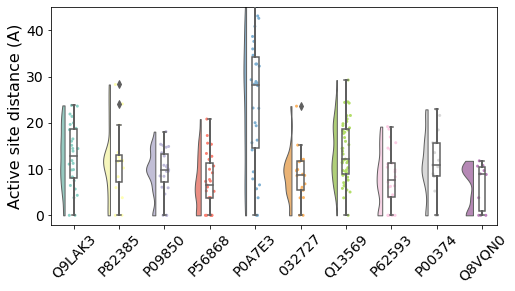

In [641]:
dy=Q9LAK3_blue_pred_distribution +SOR_blue_pred_distribution+XYNA_blue_pred_distribution+MURL_blue_pred_distribution+\
P0A7E3_blue_pred_distribution +SP2AB_blue_pred_distribution+TDG_H_blue_pred_distribution+BETA_blue_pred_distribution+DHFR_blue_pred_distribution+\
Q8VQN0_blue_pred_distribution
dx=['Q9LAK3' for i in range(len(Q9LAK3_blue_pred_distribution))]+['P82385' for i in range(len(SOR_blue_pred_distribution))]+['P09850' for i in range(len(XYNA_blue_pred_distribution))]+\
['P56868' for i in range(len(MURL_blue_pred_distribution))]+['P0A7E3' for i in range(len(P0A7E3_blue_pred_distribution))]+['O32727' for i in range(len(SP2AB_blue_pred_distribution))]+\
['Q13569' for i in range(len(TDG_H_blue_pred_distribution))]+['P62593' for i in range(len(BETA_blue_pred_distribution))]+['P00374' for i in range(len(DHFR_blue_pred_distribution))]+\
['Q8VQN0' for i in range(len(Q8VQN0_blue_pred_distribution))]


f, ax = plt.subplots(figsize=(8, 4))




ort = "h"; pal = "Set3"; sigma = .2
pt.RainCloud(y = dy,
             x = dx,
             bw = .3, width_viol = .5, ax = ax,palette=pal)

ax.set_ylabel('Active site distance (A)',fontsize=16)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(-2,45)

dx_labels=['Q9LAK3','P82385','P09850','P56868','P0A7E3','032727','Q13569','P62593','P00374','Q8VQN0']
ax.set_xticklabels(dx_labels,rotation=45,fontsize=14)
plt.savefig('./Figures/SBIR_distance_from_active_site_MCSA_1.pdf')

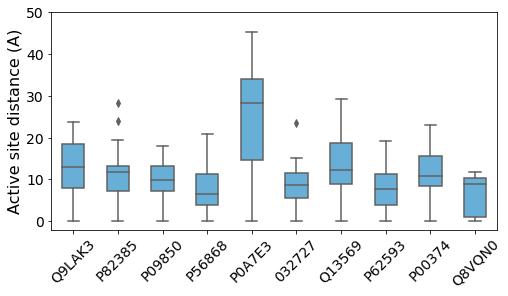

In [642]:
dy=Q9LAK3_blue_pred_distribution +SOR_blue_pred_distribution+XYNA_blue_pred_distribution+MURL_blue_pred_distribution+\
P0A7E3_blue_pred_distribution +SP2AB_blue_pred_distribution+TDG_H_blue_pred_distribution+BETA_blue_pred_distribution+DHFR_blue_pred_distribution+\
Q8VQN0_blue_pred_distribution
dx=['Q9LAK3' for i in range(len(Q9LAK3_blue_pred_distribution))]+['P82385' for i in range(len(SOR_blue_pred_distribution))]+['P09850' for i in range(len(XYNA_blue_pred_distribution))]+\
['P56868' for i in range(len(MURL_blue_pred_distribution))]+['P0A7E3' for i in range(len(P0A7E3_blue_pred_distribution))]+['O32727' for i in range(len(SP2AB_blue_pred_distribution))]+\
['Q13569' for i in range(len(TDG_H_blue_pred_distribution))]+['P62593' for i in range(len(BETA_blue_pred_distribution))]+['P00374' for i in range(len(DHFR_blue_pred_distribution))]+\
['Q8VQN0' for i in range(len(Q8VQN0_blue_pred_distribution))]

f, ax = plt.subplots(figsize=(8, 4))




ort = "h"; color = "green"; sigma = .2
sns.boxplot(y = dy,
             x = dx,
             width = .5, ax = ax,color="#56B4E9")
ax.set_ylabel('Active site distance (A)',fontsize=16)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(-2,50)

dx_labels=['Q9LAK3','P82385','P09850','P56868','P0A7E3','032727','Q13569','P62593','P00374','Q8VQN0']
ax.set_xticklabels(dx_labels,rotation=45,fontsize=14)
plt.savefig('./Figures/SBIR_bar_distance_from_active_site_MCSA_1.pdf')

In [643]:
total_dist=0
count_close=0
for i in dy:
    total_dist+=1
    if i <10:
        count_close+=1
        
print(count_close,total_dist)

113 240


### Statistics
data imported from notebook (2/2)

In [647]:
print(count_MCSA_matched_over_threshold)

26


In [648]:
print(count_total_SBI_predicted)

[5104, 202]


In [649]:
statistic_threshold_SBI_MCSA=[[0.9,11,57],[0.8,16,91],[0.7,17,121],[0.5,22,161],[0.4,22,189],[0.3,23,223],[0.2,25,272],[0.01,27,487]]

In [650]:
print(count_catalytic_residues)
count_catalytic_residues=np.array(count_catalytic_residues)
np.save('./outputs/count_catalytic_residues_array_1.npy', count_catalytic_residues)

[ 2 26  3  0  1]


In [651]:
print(count_total_variant)
count_total_variant=np.array(count_total_variant)
np.save('./outputs/count_total_variant_array_1.npy', count_total_variant)

[19701  5817  8580     0]


In [652]:
6000/(10077+6000+7924+1097)

0.2390628735357399

In [653]:
print(count_total_residues)
count_total_residues=np.array(count_total_residues)
np.save('./outputs/count_total_residues_array_1.npy', count_total_residues)

[1002  230  488    0   75]
